# EfficientNet V2

In [1]:
import tensorflow as tf

# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.image.decode_jpeg(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img
  
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")
  
  
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.

  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"

  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback
  

# Walk through an image classification directory and find out how many files (images)
# are in each subdirectory.
import os

def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.

  Args:
    dir_path (str): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [2]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import seaborn as sns

import keras

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

sns.set(style='darkgrid')

from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

In [3]:
def walk_through_dir(dir_path):
  """
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [4]:
from pathlib import Path
import os.path

BATCH_SIZE = 32
TARGET_SIZE = (224 , 224)
dataset = "agricultural-pests-image-dataset"

walk_through_dir(dataset)


There are 12 directories and 0 images in 'agricultural-pests-image-dataset'.
There are 0 directories and 499 images in 'agricultural-pests-image-dataset\ants'.
There are 0 directories and 500 images in 'agricultural-pests-image-dataset\bees'.
There are 0 directories and 416 images in 'agricultural-pests-image-dataset\beetle'.
There are 0 directories and 434 images in 'agricultural-pests-image-dataset\catterpillar'.
There are 0 directories and 323 images in 'agricultural-pests-image-dataset\earthworms'.
There are 0 directories and 466 images in 'agricultural-pests-image-dataset\earwig'.
There are 0 directories and 485 images in 'agricultural-pests-image-dataset\grasshopper'.
There are 0 directories and 497 images in 'agricultural-pests-image-dataset\moth'.
There are 0 directories and 391 images in 'agricultural-pests-image-dataset\slug'.
There are 0 directories and 500 images in 'agricultural-pests-image-dataset\snail'.
There are 0 directories and 498 images in 'agricultural-pests-image

In [5]:
def convert_path_to_df(dataset):
    image_dir = Path(dataset)
    # Get filepaths and labels
    filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpeg')) + list(image_dir.glob(r'**/*.png'))+list(image_dir.glob(r'**/*.PNG'))

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    image_df = pd.concat([filepaths, labels], axis=1)
   
    return image_df
    
image_df = convert_path_to_df(dataset)

In [6]:
image_df

Filepath  Label
0     agricultural-pests-image-dataset\ants\ants (1)...   ants
1     agricultural-pests-image-dataset\ants\ants (10...   ants
2     agricultural-pests-image-dataset\ants\ants (10...   ants
3     agricultural-pests-image-dataset\ants\ants (10...   ants
4     agricultural-pests-image-dataset\ants\ants (10...   ants
...                                                 ...    ...
5498  agricultural-pests-image-dataset\moth\moth (1)...   moth
5499  agricultural-pests-image-dataset\slug\slug (1)...   slug
5500  agricultural-pests-image-dataset\slug\slug (2)...   slug
5501  agricultural-pests-image-dataset\snail\snail (...  snail
5502  agricultural-pests-image-dataset\wasp\WASP (1)...   wasp

[5503 rows x 2 columns]

In [7]:
# Check for corrupted images within the dataset
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path("agricultural-pests-image-dataset").rglob("*.jpg")
for imp_p in path:
    try:
        img = PIL.Image.open(imp_p)
    except PIL.UnidentifiedImageError:
        print(imp_p)

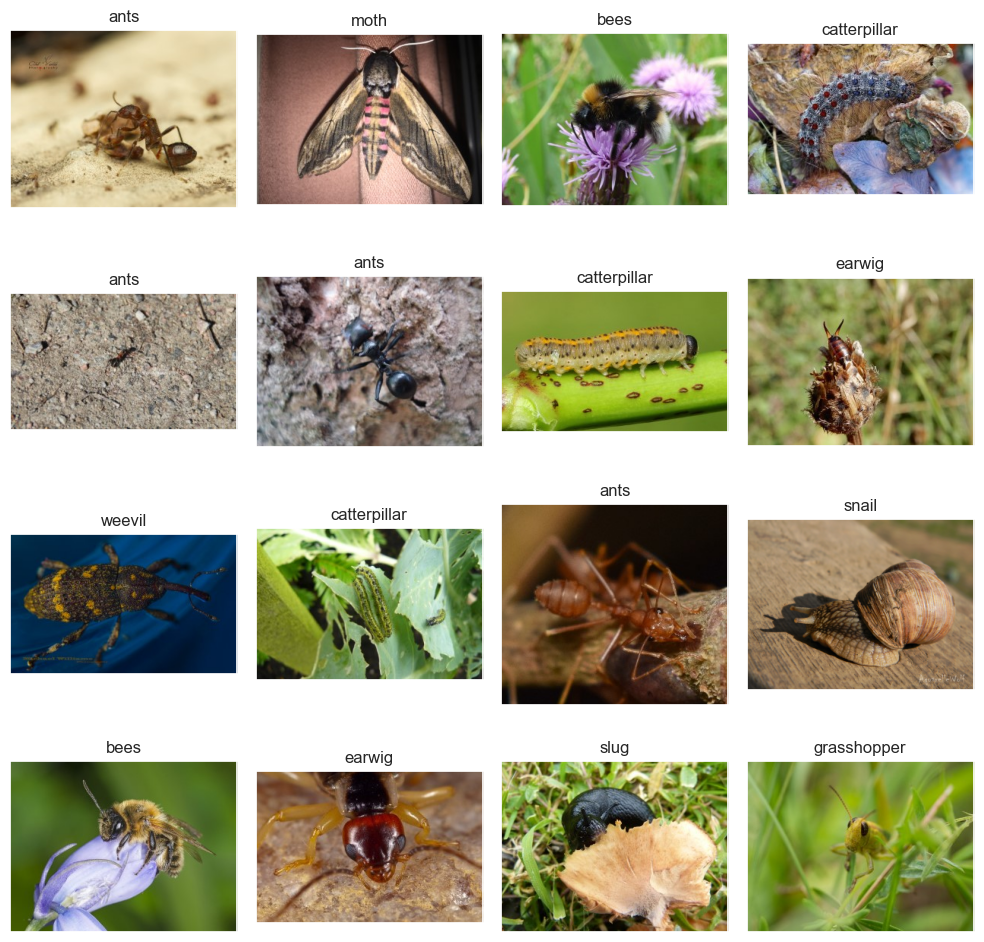

In [8]:
import matplotlib.image as mpimg
# display 16 picture of dataset with labels

random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
#     image = Image.open(image_df.Filepath[random_index[i]])
#     ax.imshow(image)
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [8]:
train_df , test_df = train_test_split(image_df, test_size= 0.2, shuffle= True, random_state= 42)

In [9]:
train_generator = ImageDataGenerator(
    preprocessing_function = keras.applications.efficientnet_v2.preprocess_input, 
    validation_split = 0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function = keras.applications.efficientnet_v2.preprocess_input
)

In [10]:
train_images = train_generator.flow_from_dataframe(
    dataframe= train_df,
    x_col= 'Filepath',
    y_col= 'Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size= 32,
    shuffle= True,
    seed= 42 ,
    subset= 'training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe= train_df,
    x_col= 'Filepath',
    y_col= 'Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size= 32,
    shuffle= True,
    seed= 42 ,
    subset= 'validation'
)


test_images = test_generator.flow_from_dataframe(
    dataframe= test_df,
    x_col= 'Filepath',
    y_col= 'Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size= 32,
    shuffle= False,
)

Found 3522 validated image filenames belonging to 12 classes.
Found 880 validated image filenames belonging to 12 classes.
Found 1101 validated image filenames belonging to 12 classes.


In [11]:
# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
])

The model images will be subjected to a pre-trained CNN model called Efficientnet_v2. Three callbacks will be utilized to monitor the training. These are: Model Checkpoint, Early Stopping, Tensorboard callback. The summary of the model hyperparameter is shown as follows:

Batch size: 32
Epochs:20
Input Shape: (224, 224, 3)
Output layer: 12

In [12]:
# Load the pretained model
pretrained_model = keras.applications.efficientnet_v2.EfficientNetV2L(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

In [14]:
pretrained_model.summary()

Model: "efficientnetv2-l"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 32  864         ['rescaling_1[0][0]']            
                                )                                                                 
                                                                                   

In [13]:
# Create checkpoint callback
checkpoint_path = "pests_cats_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [14]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 8,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

In [15]:
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.

  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"

  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

# Plot the validation and training data separately

In [37]:
inputs = pretrained_model.input
x = augment(inputs)

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.45)(x)


outputs = Dense(12, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=20,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "pests_cats_classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/pests_cats_classification/20230508-081721
Epoch 1/20
111/111 [==============================] - 2821s 22s/step - loss: 6.0819 - accuracy: 0.0835 - val_loss: 2.7732 - val_accuracy: 0.1239
Epoch 2/20
111/111 [==============================] - 2789s 25s/step - loss: 4.1912 - accuracy: 0.1068 - val_loss: 2.2859 - val_accuracy: 0.2648
Epoch 3/20
111/111 [==============================] - 2547s 23s/step - loss: 3.3019 - accuracy: 0.1246 - val_loss: 2.1185 - val_accuracy: 0.3932
Epoch 4/20
111/111 [==============================] - 2216s 20s/step - loss: 2.7914 - accuracy: 0.1496 - val_loss: 2.0184 - val_accuracy: 0.4886
Epoch 5/20
111/111 [==============================] - 2587s 23s/step - loss: 2.5195 - accuracy: 0.1834 - val_loss: 1.9516 - val_accuracy: 0.5227
Epoch 6/20
111/111 [==============================] - 3543s 32s/step - loss: 2.3540 - accuracy: 0.2087 - val_loss: 1.9091 - val_accuracy: 0.5659
Epoch 7/20
111/111 [=====================

After 10 epochs
Accuracy : 67.03 %

In [38]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuarcy:{:.2f}%".format(results[1]*100)) 

    Test Loss: 1.13801
Test Accuarcy:74.02%


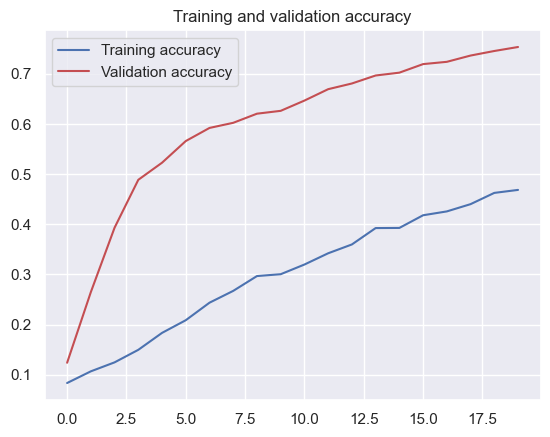

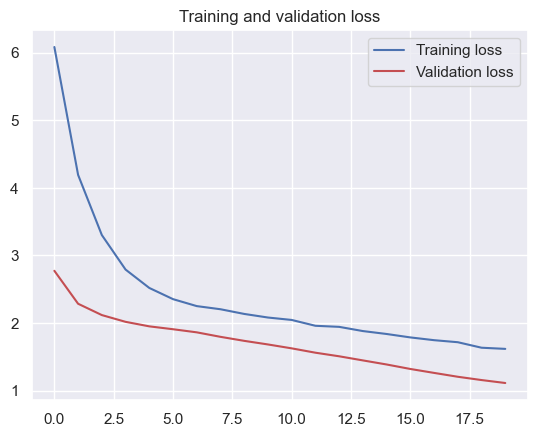

In [39]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

In [40]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

35/35 [==============================] - 590s 15s/step
The first 5 predictions: ['slug', 'slug', 'snail', 'wasp', 'catterpillar']


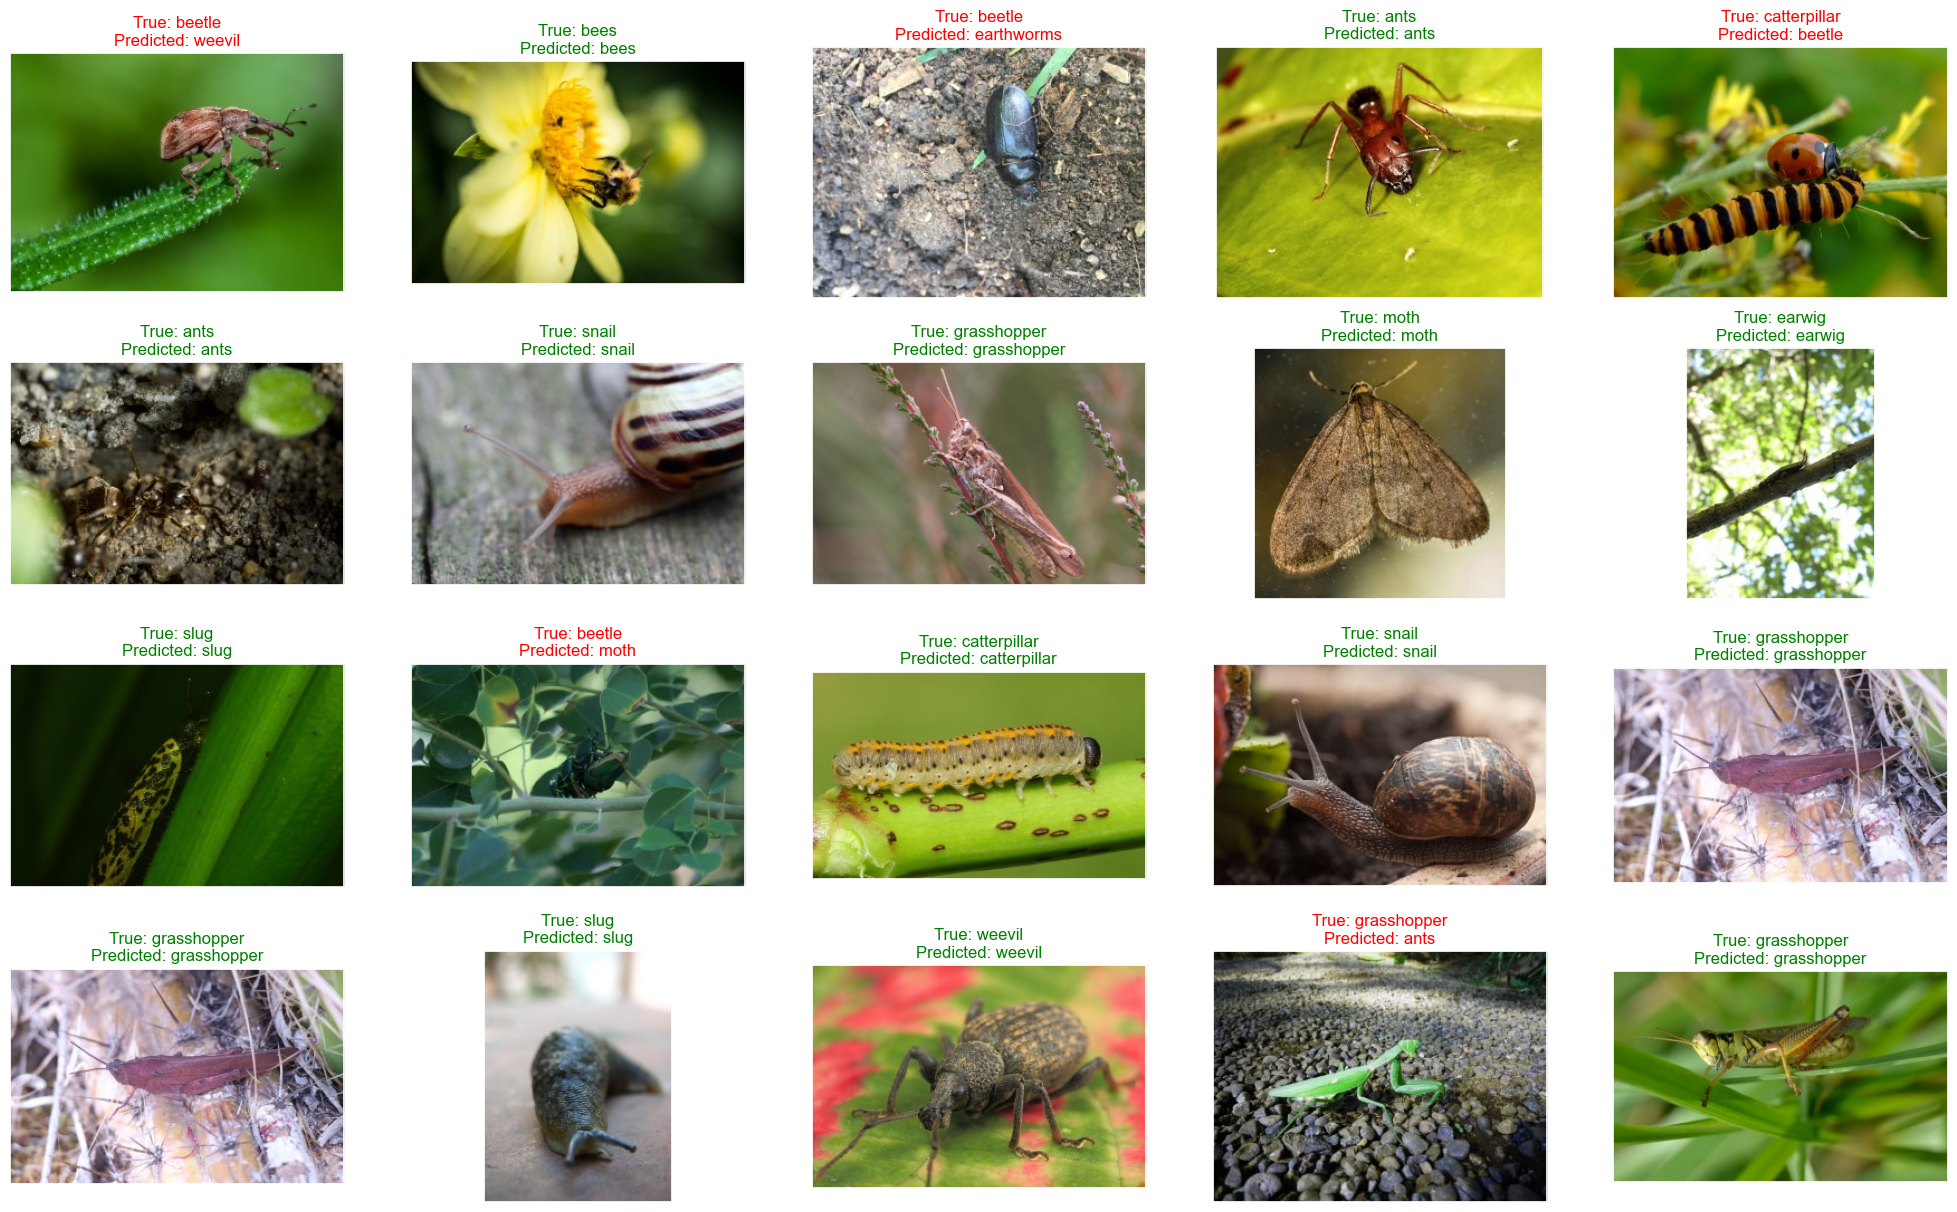

<Figure size 640x480 with 0 Axes>

In [41]:
# Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 20)
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [42]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

        ants       0.84      0.97      0.90       122
        bees       0.70      0.88      0.78        94
      beetle       0.78      0.32      0.46        87
catterpillar       0.48      0.35      0.40        92
  earthworms       0.54      0.28      0.37        67
      earwig       0.65      0.56      0.60       102
 grasshopper       0.74      0.82      0.77        82
        moth       0.61      0.88      0.72        85
        slug       0.76      0.84      0.80        81
       snail       0.95      1.00      0.98       104
        wasp       0.83      0.78      0.80        89
      weevil       0.78      0.99      0.87        96

    accuracy                           0.74      1101
   macro avg       0.72      0.72      0.71      1101
weighted avg       0.73      0.74      0.72      1101



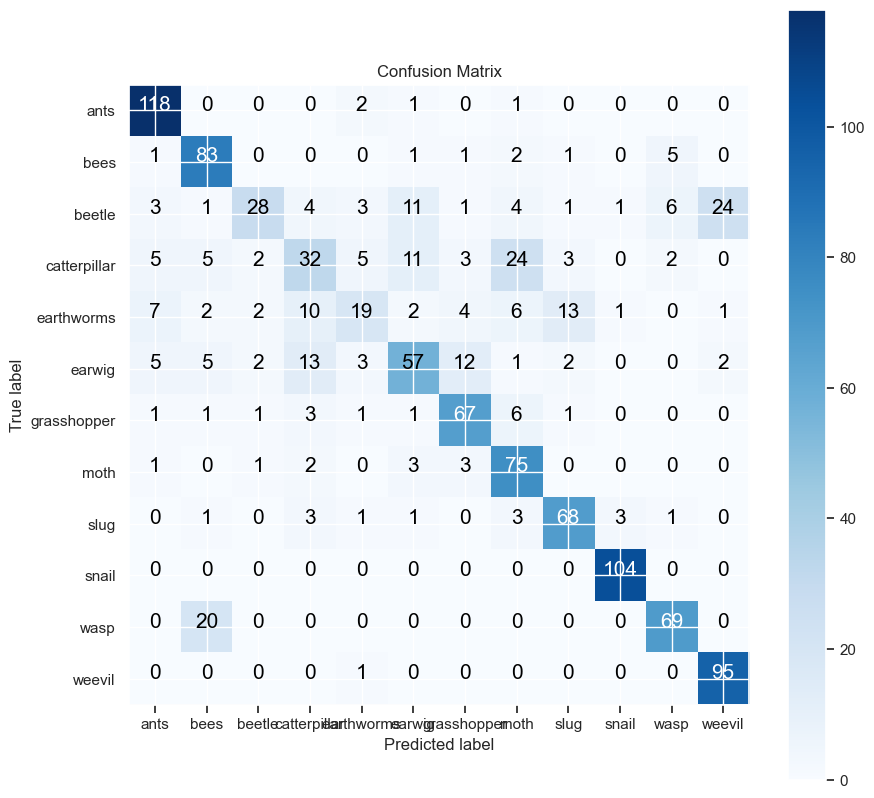

In [43]:
make_confusion_matrix(y_test, pred, list(labels.values()))

# CNN Keras


we can build an easy model composed of different layers such as:

- Conv2D: (32 filters of size 3 by 3) The features will be "extracted" from the image.
- MaxPooling2D: The images get half sized.
- Flatten: Transforms the format of the images from a 2d-array to a 1d-array of 150 150 3 pixel values.
- Relu : given a value x, returns max(x, 0).
- Softmax: 12 neurons, probability that the image belongs to one of the classes.

In [16]:
model_cnn = keras.Sequential([
    keras.layers.Conv2D(32,(3,3), activation='relu', input_shape = (224, 224, 3)),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(32, (3, 3), activation= 'relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation= tf.nn.relu),
    keras.layers.Dense(12, activation=tf.nn.softmax)
])

In [17]:
model_cnn.compile(optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [19]:
history = model_cnn.fit(train_images,steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=30
    )

Epoch 1/30
111/111 [==============================] - 397s 4s/step - loss: 30.4480 - accuracy: 0.1300 - val_loss: 4.3328 - val_accuracy: 0.1773
Epoch 2/30
111/111 [==============================] - 359s 3s/step - loss: 3.7871 - accuracy: 0.2570 - val_loss: 4.2858 - val_accuracy: 0.1920
Epoch 3/30
111/111 [==============================] - 265s 2s/step - loss: 1.8298 - accuracy: 0.4844 - val_loss: 3.3949 - val_accuracy: 0.2500
Epoch 4/30
111/111 [==============================] - 269s 2s/step - loss: 1.0379 - accuracy: 0.6698 - val_loss: 3.1691 - val_accuracy: 0.2284
Epoch 5/30
111/111 [==============================] - 265s 2s/step - loss: 0.5670 - accuracy: 0.8296 - val_loss: 3.2722 - val_accuracy: 0.2807
Epoch 6/30
111/111 [==============================] - 285s 3s/step - loss: 0.2840 - accuracy: 0.9347 - val_loss: 3.2038 - val_accuracy: 0.3023
Epoch 7/30
111/111 [==============================] - 342s 3s/step - loss: 0.1626 - accuracy: 0.9699 - val_loss: 3.5841 - val_accuracy: 0.308

In [20]:
results = model_cnn.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuarcy:{:.2f}%".format(results[1]*100)) 

    Test Loss: 5.50468
Test Accuarcy:27.61%


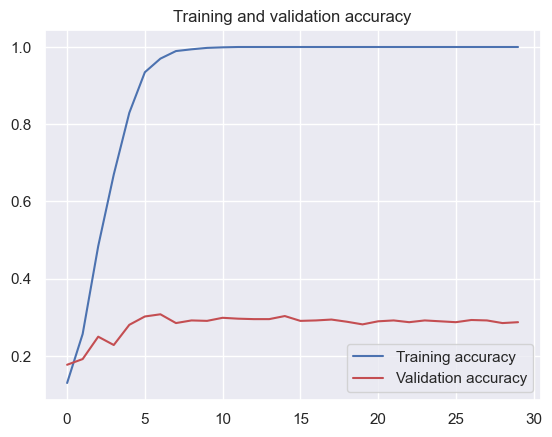

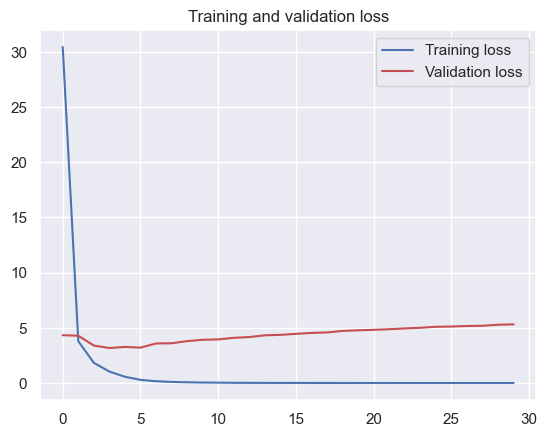

In [21]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()